In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
dataset = np.load("proyecto_training_data.npy")
dataset = dataset[~np.isnan(dataset).any(axis=1), :] #Dataset contiene nans, los ignoro en la implementacion
fields = ["SalePrice", "OverallQual", "1stFlrSF", "TotRmsAbvGrd", "YearBuilt", "LotFrontage"]
print(np.vstack((np.array(fields), dataset)))

[['SalePrice' 'OverallQual' '1stFlrSF' 'TotRmsAbvGrd' 'YearBuilt'
  'LotFrontage']
 ['208500.0' '7.0' '856.0' '8.0' '2003.0' '65.0']
 ['181500.0' '6.0' '1262.0' '6.0' '1976.0' '80.0']
 ...
 ['266500.0' '7.0' '1188.0' '9.0' '1941.0' '66.0']
 ['142125.0' '5.0' '1078.0' '5.0' '1950.0' '68.0']
 ['147500.0' '5.0' '1256.0' '6.0' '1965.0' '75.0']]


# Train/Test split

In [3]:
rows, cols = dataset.shape
train = dataset[-int(np.round(0.8*rows)):]
test = dataset[int(np.round(0.8*rows)):]
print(train.shape)
print(test.shape)

(961, 6)
(240, 6)


# Resumen estadistico

In [4]:
datasetdf = pd.DataFrame(dataset, columns = fields)
datasetdf.aggregate(['mean', 'max', 'min', 'ptp', 'std'])

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
mean,180770.480433,6.122398,1158.437968,6.535387,1970.580350,70.049958
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
ptp,720100.000000,9.000000,4358.000000,12.000000,138.000000,292.000000
std,83389.519866,1.419216,386.257235,1.629608,31.750335,24.284752


# Distplots

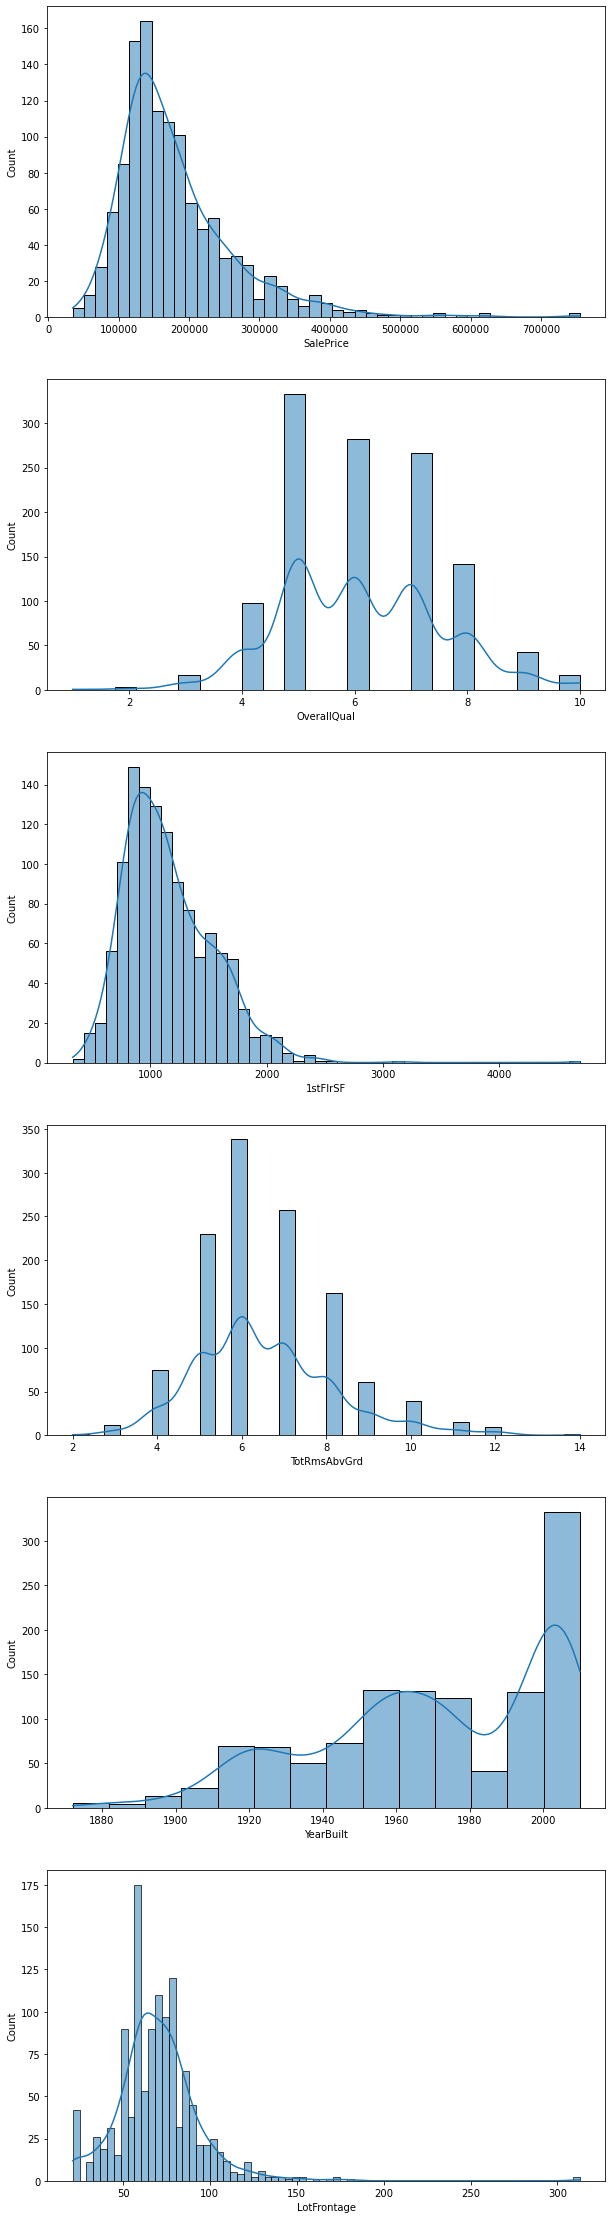

In [5]:
plt.figure(figsize=(10,40))
for i, field in enumerate(fields, 1):
    plt.subplot(6,1,i)
    sns.histplot(datasetdf[field], kde=True) # Uso histplot para evitar la advertencia de deprecacion de distplot

# Scatterplots

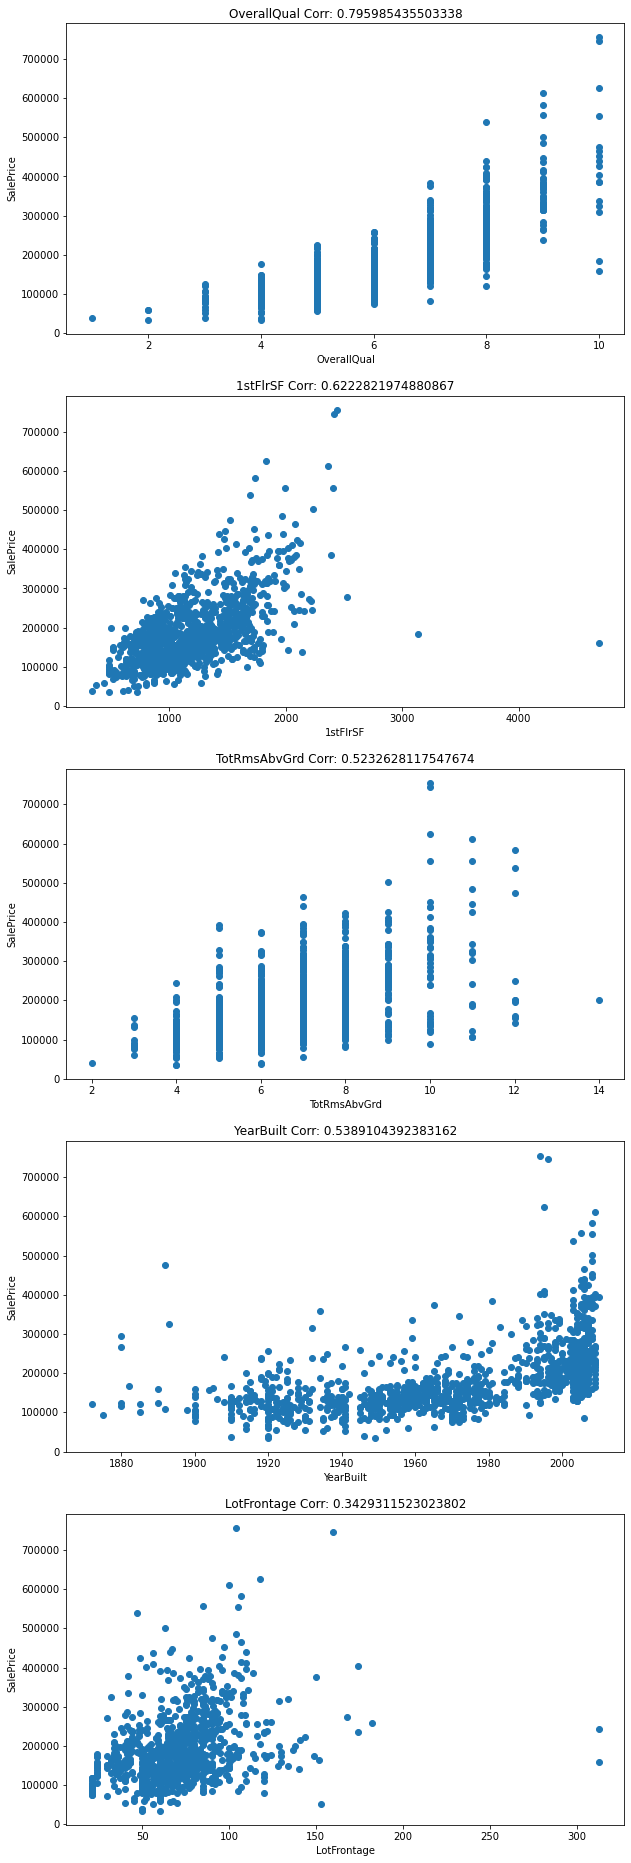

In [6]:
corrcoefs = np.corrcoef(train, rowvar=False)
plt.figure(figsize=(10,40))
for i, field in enumerate(fields[1:], 1):
    plt.subplot(6,1,i)
    plt.title(field + f" Corr: {corrcoefs[0, i]}")
    plt.ylabel(fields[0])
    plt.xlabel(fields[i])
    plt.scatter(dataset[:, i], dataset[:, 0])

### Variables seleccionadas: OverallQual y 1stFlrSF

# Fucion de entrenamiento

In [7]:
def training(x, y, epochs, imprimir_error_cada, lr):
    x_mat = np.column_stack((x, np.ones_like(x)))
    mb = (1,1)
    y_hat = 0
    errors = []
    result = {}
    for i in range(0, epochs):
        y_hat = np.matmul(x_mat,mb)
        error = 0.5*np.mean(np.power(y-y_hat, 2))
        if (imprimir_error_cada > 0) and (((i+1) % imprimir_error_cada) == 0):
            print(error)
        errors.append(error)
        grads = np.mean((y_hat-y).reshape(-1,1) * x_mat, axis = 0)
        mb = (mb[0] - lr*grads[0], mb[1] - lr*grads[1])
        result[i+1] = (mb) 
    return result, errors
        

In [8]:
training([65, 80, 68], [208.5, 181.5, 223.5], 4, 2, 0.01)

20995846.047975
129547891826493.52


({1: (93.69500000000001, 2.325),
  2: (-4526.2376, -62.1767),
  3: (225730.80006500002, 3154.1187630000004),
  4: (-11250260.95656068, -157144.24547078)},
 [9046.125, 20995846.047975, 52152571521.80706, 129547891826493.52])

# Grafica de Loss

In [9]:
def lossgraph(errors):
    sns.lineplot(x=np.arange(1,len(errors)+1), y=errors)
    plt.title("Loss")
    plt.xlabel("Iteracion")
    plt.ylabel("Error")

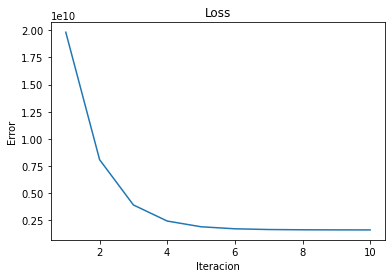

In [10]:
model_results, errors = training(train[:,1], train[:,0], 10, 0, 0.01)
lossgraph(errors)

# Grafica de la recta resultante del modelo

In [11]:
def modelgraph(results, x, y, n = 3):
    plt.scatter(x, y)
    x_mat = np.column_stack((x, np.ones_like(x)))
    for i in range(1, len(results)+1, n):
        plt.plot(x,np.matmul(x_mat, results[i]))
    plt.title("Scatter")
    plt.ylabel("SalePrice")
    plt.xlabel("X")

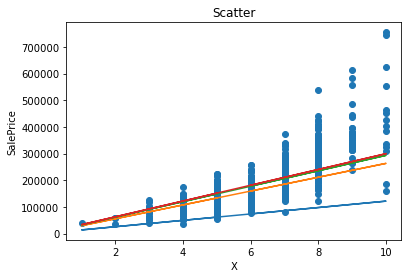

In [12]:
modelgraph(model_results, train[:,1], train[:,0], n=3)

# Entrenando con OverallQual

In [13]:
min_error_OQ = np.inf
best_model_OQ = None
best_epochs_OQ = 0
best_lr_OQ = 0
best_results_OQ = None
best_errors_OQ = None
for epochs in (100, 1000, 10000, 100000):
    for lr in (0.1, 0.01, 0.001):
        model_results, errors = training(train[:,1], train[:,0], epochs, 0, lr)
        errors = np.nan_to_num(errors, nan=np.inf)
        if min(errors) < min_error_OQ:
            min_error_OQ = np.nanmin(errors)
            best_results_OQ = model_results
            best_errors_OQ = errors
            best_model_OQ = model_results[np.nanargmin(errors)+1]
            best_epochs_OQ = epochs
            best_lr_OQ = lr
print(best_model_OQ)
print(best_epochs_OQ)
print(best_lr_OQ)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\yanco\AppData\Local\Temp/ipykernel_17380/289951443.py:9: RuntimeWarning: overflow encountered in power
  error = 0.5*np.mean(np.power(y-y_hat, 2))
C:\Users\yanco\AppData\Local\Temp/ipykernel_17380/289951443.py:14: RuntimeWarning: invalid value encountered in double_scalars
  mb = (mb[0] - lr*grads[0], mb[1] - lr*grads[1])


(46997.30049393085, -107077.38113822472)
100000
0.01


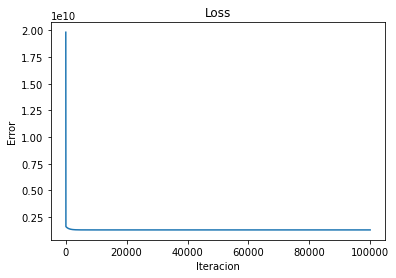

In [14]:
lossgraph(best_errors_OQ)

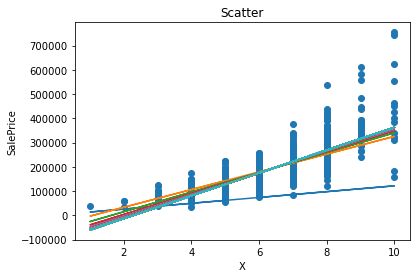

In [15]:
modelgraph(best_results_OQ, train[:,1], train[:,0], n=1000)

# Entrenando con 1stFlrSF

In [16]:
min_error_1st = np.inf
best_model_1st = None
best_epochs_1st = 0
best_lr_1st = 0
best_results_1st = None
best_errors_1st = None
for epochs in (100, 1000, 10000, 100000):
    for lr in (0.001, 0.00001, 0.00000001, 0.00000000001):
        model_results, errors = training(train[:,2], train[:,0], epochs, 0, lr)
        errors = np.nan_to_num(errors, nan=np.inf)
        if min(errors) < min_error_1st:
            min_error_1st = np.nanmin(errors)
            best_results_1st = model_results
            best_errors_1st = errors
            best_model_1st = model_results[np.nanargmin(errors)+1]
            best_epochs_1st = epochs
            best_lr_1st = lr
print(best_model_1st)
print(best_epochs_1st)
print(best_lr_1st)

C:\Users\yanco\AppData\Local\Temp/ipykernel_17380/289951443.py:9: RuntimeWarning: overflow encountered in power
  error = 0.5*np.mean(np.power(y-y_hat, 2))
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\yanco\AppData\Local\Temp/ipykernel_17380/289951443.py:14: RuntimeWarning: invalid value encountered in double_scalars
  mb = (mb[0] - lr*grads[0], mb[1] - lr*grads[1])


(153.9872436033203, 3.776061301355901)
100000
1e-08


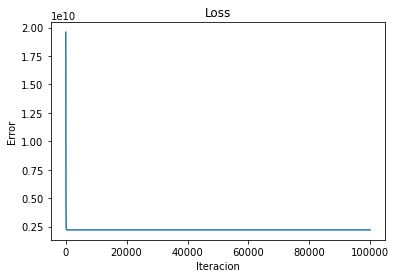

In [17]:
lossgraph(best_errors_1st)

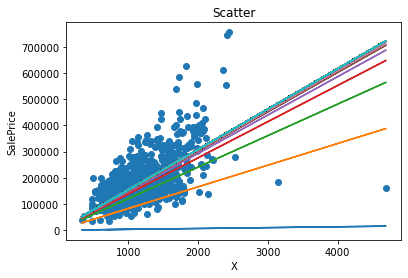

In [18]:
modelgraph(best_results_1st, train[:,2], train[:,0], n=50)

# Entrenando con OverallQual usando SciKit Learn

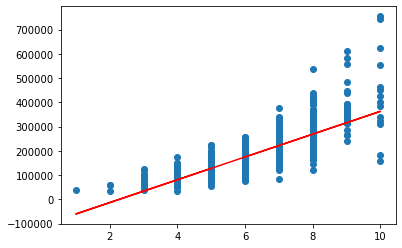

In [19]:
reg_OQ = LinearRegression().fit(train[:, np.newaxis, 1], train[:,0])
plt.scatter(train[:,1], train[:,0])
plt.plot(train[:,1], reg_OQ.predict(train[:, np.newaxis, 1]), 'red')

# Entrenando con 1stFlrSF usando SciKit Learn

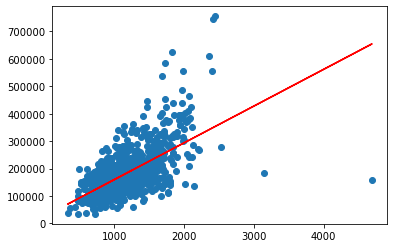

In [20]:
reg_1st = LinearRegression().fit(train[:, np.newaxis, 2], train[:,0])
plt.scatter(train[:,2], train[:,0])
plt.plot(train[:,2], reg_1st.predict(train[:, np.newaxis, 2]), 'red')

# Funcion que promedia predicciones

In [21]:
def mean_predictor(manual_model, scikit_model, x):
    x_mat = np.column_stack((x, np.ones_like(x)))
    mb = (manual_model[0], manual_model[1])
    y_hat = np.matmul(x_mat,mb)
    sci_pred = scikit_model.predict(x.reshape(-1, 1))
    return y_hat.reshape(-1,1), sci_pred.reshape(-1,1), np.mean([y_hat, sci_pred], axis=0).reshape(-1,1)

In [22]:
manual_OQ, sci_OQ, mean_OQ = mean_predictor(best_model_OQ, reg_OQ, test[:,1])

In [23]:
manual_1st, sci_1st, mean_1st = mean_predictor(best_model_1st, reg_1st, test[:,1])

# Comparando errores

In [24]:
error_manual_OQ = 0.5*np.mean(np.power(test[:,0]-manual_OQ, 2))
error_sci_OQ = 0.5*np.mean(np.power(test[:,0]-sci_OQ, 2))
error_mean_OQ = 0.5*np.mean(np.power(test[:,0]-mean_OQ, 2))

In [25]:
error_manual_1st = 0.5*np.mean(np.power(test[:,0]-manual_1st, 2))
error_sci_1st = 0.5*np.mean(np.power(test[:,0]-sci_1st, 2))
error_mean_1st = 0.5*np.mean(np.power(test[:,0]-mean_1st, 2))

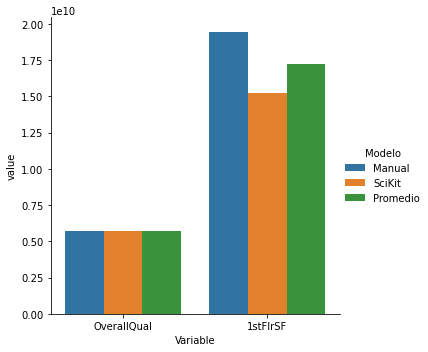

In [26]:
dfe = pd.DataFrame(data={'Variable': ['OverallQual','1stFlrSF'], 
                         'Manual': [error_manual_OQ, error_manual_1st], 
                         'SciKit': [error_sci_OQ, error_sci_1st], 
                         'Promedio': [error_mean_OQ, error_mean_1st]})
dfe1 = pd.melt(dfe, id_vars = "Variable",var_name="Modelo")
sns.catplot(x = 'Variable', y='value', 
            hue = 'Modelo',data=dfe1, 
            kind='bar')

# Conclusion

El mejor modelo es el que esta basado en OverallQual, parece que no existe mayor diferencia entre los resultados de los tres tipos de entrenamiento, asi que la eleccion final depende de otros factores como regla de negocio (si se quiere eliminar dependencia de librerias externas, por ejemplo, seria mejor el modelo entrenado manualmente).